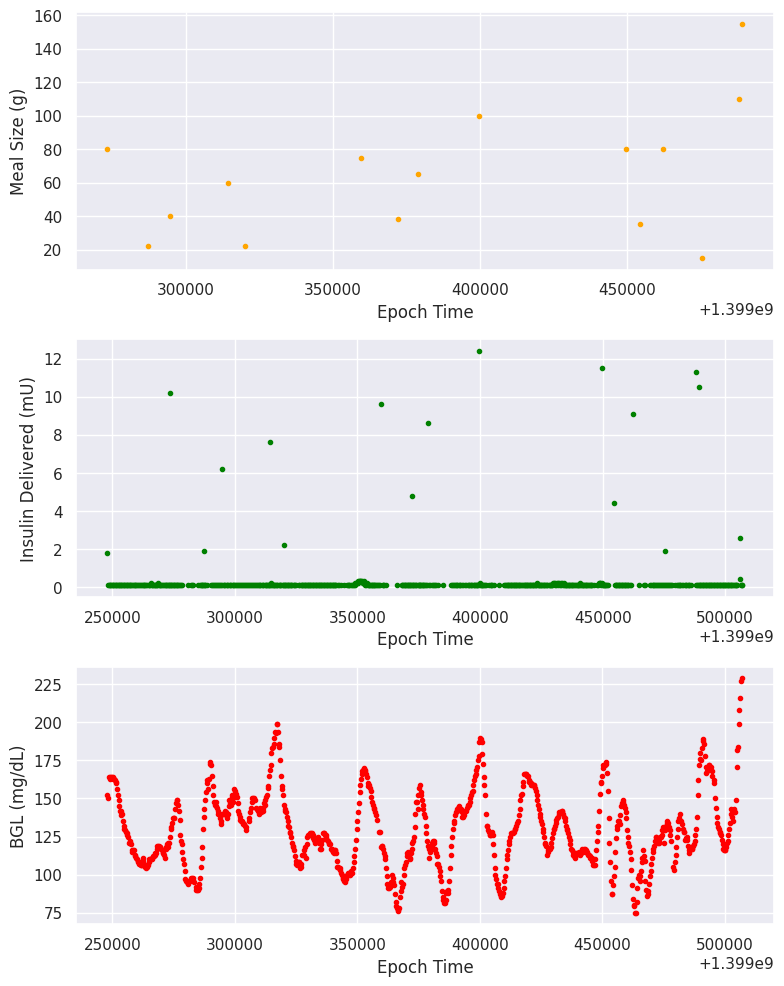

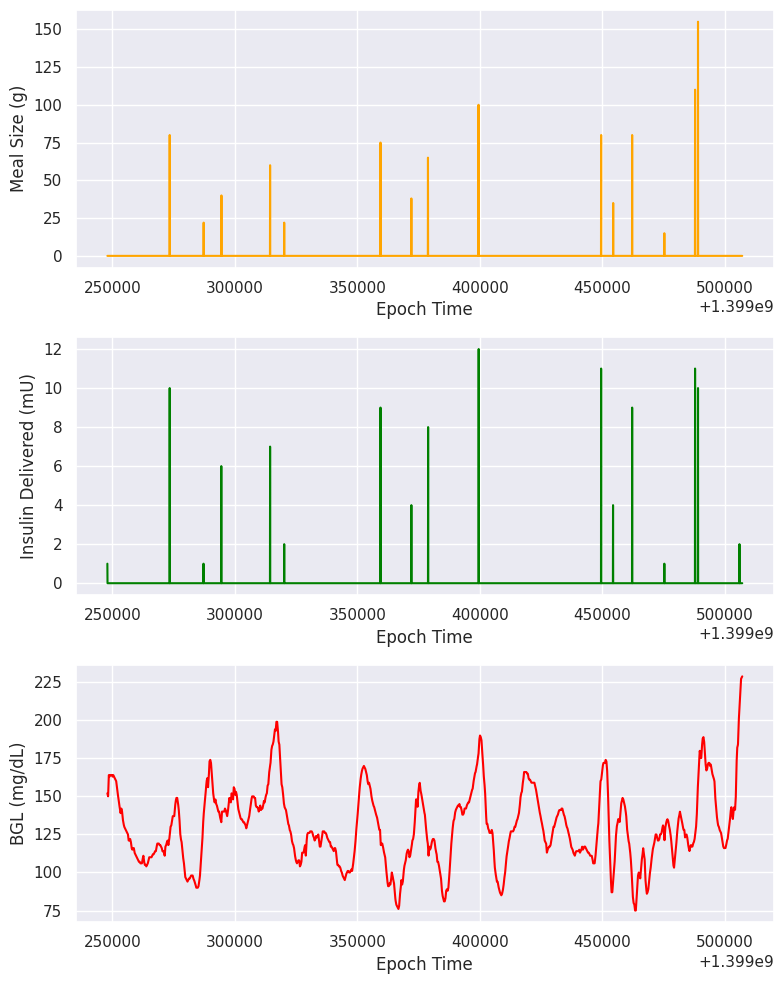

In [ ]:
%run "preprocess.ipynb"


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from datetime import timedelta, datetime
import simglucose
from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from tqdm.notebook import tqdm, trange
from deap import base, creator, tools, cma

from utils import dt2int
from data import C3RData, interpolate
from IPython.display import clear_output

In [ ]:
!pip install deap
import deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install simglucose
import simglucose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# config
GLOBAL_SEED = 0
RESULTS_PATH = "results/"
START_TIME = datetime.now()

# better plots
sns.set()

# tqdm
tqdm.pandas()

In [ ]:
# load dataset
c3r = C3RData(data_dir="data")

# get data for a certain case
deident_id = 2
from_dt = f"2014-05-05 00:00:00"
to_dt = f"2014-05-06 00:00:00"

# destructure data
cgm_data, meal_data, insulin_data = c3r.get_case(deident_id, from_dt, to_dt)
data_t, data_CGM, data_CHO, data_insulin = interpolate(cgm_data, meal_data, insulin_data)

# normalize time
data_t -= data_t[0]

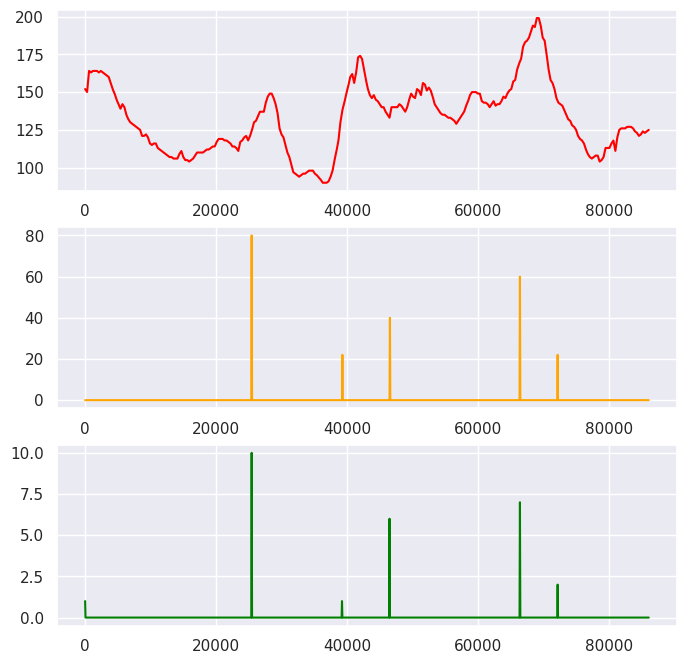

In [ ]:
# visualize data
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(data_t, data_CGM, label="CGM", color="red")
plt.subplot(3, 1, 2)
plt.plot(data_t, data_CHO, label="CHO", color="orange")
plt.subplot(3, 1, 3)
plt.plot(data_t, data_insulin, label="insulin", color="green")
plt.show()

In [ ]:
scen = [[data_t[i] / (60 * 60), 3 * data_CHO[i]] for i in np.where(data_CHO > data_CHO[0])[0]]
case_scenario = CustomScenario(start_time=datetime.now(), scenario=scen)

In [ ]:
# load parameters
orig_params = pd.read_csv("/content/vpatient_params.csv")
nominal_params = orig_params.mean(numeric_only=True)
est_params = ["kp2", "k1", "k2", "kp1", "ki", "ke1", "kmax", "kmin", "kabs", "kp3"]

# constrain parameters to be within the range
adult_params = orig_params[orig_params.Name.str.contains("adult")].loc[:, est_params]
p_min = adult_params.min() / 5
p_max = adult_params.max() * 5
p_range = np.stack([p_min, p_max], axis=1)
def constrain_params(p):
    return ((np.tanh(p) + 1) / 2) * (p_range[:, 1] - p_range[:, 0]) + p_range[:, 0]

# construct parameter dict
def construct_params(p):
    # p = [kp2, k1, k2, kp1, ki, ke1, kmax, kmin, kabs, kp3]
    return {
        **nominal_params.drop("i").to_dict(),
        **dict(zip(est_params, constrain_params(p))),
    }

In [ ]:
est_mean = orig_params.loc[orig_params.Name.str.contains("adult")].mean(numeric_only=True).loc[est_params]
est_std = orig_params.loc[orig_params.Name.str.contains("adult")].std(numeric_only=True).loc[est_params]

In [ ]:
def objective(params, sensor, pump, scenario, controller):
    patient = T1DPatient.withParams(params)

    env = T1DSimEnv(patient, sensor, pump, scenario)

    s = SimObj(env, controller, timedelta(days=1), animate=False, path=RESULTS_PATH)
    results = sim(s)

    t_preds = results.index.map(lambda d: dt2int(str(d), fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
    t_preds -= t_preds[0]

    cgm_preds = results.BG.to_numpy()

    return cgm_preds, t_preds

In [ ]:
sensor = CGMSensor.withName("Dexcom", seed=GLOBAL_SEED)
pump = InsulinPump.withName("Insulet")
controller = BBController()

In [ ]:
def evaluate(p):
    try:
        pred_CGM, pred_t = objective(construct_params(p), sensor, pump, case_scenario, controller)
        pred_CGM = np.interp(data_t, pred_t, pred_CGM)
        return [np.mean((pred_CGM - data_CGM) ** 2)]
    except:
        return [1e10]

In [ ]:
!pip install pyswarms
import pyswarms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# PSO parameters
N_PARTICLES = 20
N_ITERATIONS = 100
C1 = 1.49618
C2 = 1.49618
W = 0.729

# target function
def evaluate(p):
    try:
        pred_CGM, pred_t = objective(construct_params(p), sensor, pump, case_scenario, controller)
        pred_CGM = np.interp(data_t, pred_t, pred_CGM)
        return np.mean((pred_CGM - data_CGM) ** 2)
    except:
        return 1e10

# PSO algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, velocity=list, best=None)

toolbox = base.Toolbox()
toolbox.register("evaluate", evaluate)

# initialize particles
def generate_particle():
    particle = creator.Particle(np.random.uniform(low=-1, high=1, size=len(p_guess)))
    particle.velocity = np.zeros_like(p_guess)
    particle.best = None
    return particle

toolbox.register("particle", generate_particle)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)

# define update function
def update_particle(particle, best_pos):
    r1 = np.random.uniform(0, 1, len(p_guess))
    r2 = np.random.uniform(0, 1, len(p_guess))
    
    # create a new particle object for the best position
    best_particle = Particle(best_pos)
    
    particle.velocity = (W * particle.velocity
                         + C1 * r1 * (particle.best - particle)
                         + C2 * r2 * (best_particle - particle))
    
    # update position
    particle.position += particle.velocity
    particle.position = np.clip(particle.position, lb, ub)
    
    # update personal best if necessary
    if evaluate(particle.position) < evaluate(particle.best):
        particle.best = np.copy(particle.position)
        particle.best_fitness = evaluate(particle.position)
    
    return particle


toolbox.register("update", update_particle)

# track best individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda particle: particle.best.fitness.values[0] if particle.best else np.inf)
stats.register("avg_loss", np.mean)
stats.register("min_loss", np.min)
stats.register("max_loss", np.max)

/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.9/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# train loop
def train(toolbox, n_iterations, stats, halloffame):
    population = toolbox.population(n=N_PARTICLES)

    # evaluate initial particles
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for particle, fitness in zip(population, fitnesses):
        particle.fitness.values = (fitness,)
        particle.best = particle

    for _ in range(n_iterations):
        best = max(population, key=lambda particle: particle.best.fitness.values[0])
        for particle in population:
            toolbox.update(particle, best)
            particle.fitness.values = (toolbox.evaluate(particle),)
            if particle.fitness.values < particle.best.fitness.values:
                particle.best = particle

        if halloffame is not None:
            halloffame.update(population)

        record = stats.compile(population) if stats is not None else {}
        clear_output(wait=True)
        plt.plot(record["min_loss"], "r.-")
        plt.show()

    return [particle.best.fitness.values[0] for particle in population]







In [ ]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from pyswarm import pso

# evolutionary algorithm parameters
NGEN = 100
SIGMA = 1
LAMBDA = 20

# target function
def evaluate(p):
    try:
        pred_CGM, pred_t = objective(construct_params(p), sensor, pump, case_scenario, controller)
        pred_CGM = np.interp(data_t, pred_t, pred_CGM)
        return np.mean((pred_CGM - data_CGM) ** 2)
    except:
        return 1e10

# inital parameter guess
p_guess = est_mean.to_numpy()

# PSO setup
lb = np.zeros_like(p_guess) # lower bound for each parameter
ub = np.ones_like(p_guess) * 10 # upper bound for each parameter

# track best individuals
loss_history = []
def on_iteration(x, f, i):
    loss_history.append(f)
    clear_output(wait=True)
    plt.plot(loss_history, "r.-")
    plt.show()

# run PSO optimization
best_params, best_loss = pso(evaluate, lb, ub, maxiter=NGEN, swarmsize=LAMBDA, debug=True, 
                             phip=0.5, phig=0.5, omega=0.5)

# plot results
pred_CGM, pred_t = objective(construct_params(best_params), sensor, pump, case_scenario, controller)
plt.plot(data_t, data_CGM, "b--", label="actual")
plt.plot(pred_t, pred_CGM, "r", label="predicted")
plt.ylabel("CGM")
plt.xlabel("time (s)")
plt.legend()
plt.show()


No constraints given.
Best after iteration 1: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 2: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 3: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 4: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 5: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 6: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226  6.9700927
 6.69590192 6.08582985 0.10340827 6.71527332] 10000000000.0
Best after iteration 7: [8.66436491 2.51232449 6.26635598 6.00811933 9.8357226

AttributeError: ignored